# PS1: Let's build a backtester for U.S. Treasury Portfolios
In this problem set, we will develop an initial proof-of-concept backtesting system for understanding how the value of United States Treasury security portfolio's change as a function of market conditions and time.

Fill me in

Let's go!
___

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 

> __Include:__ The [include(...) function](https://docs.julialang.org/en/v1/base/base/#include) is a convenient way to load Julia code from another file. The `Include.jl` file is a Julia file that loads external packages, and various functions that we will use in the exercise. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Otherwise, packages are downloaded and then loaded.

Let's setup our environment:

In [1]:
include(joinpath(@__DIR__, "Include-solution.jl")); # this sets up the environment, we'll do this all the time, on everything we do

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Constants
Let's define some constants that we will use throughout the problem set. See the comment next to each constant for a description of its purpose, permissible values, units, etc.

In [2]:
Δt = (1/252); # units: years, time step for the lattice model, daily steps (trading days basis)
number_of_steps = 21; # project value out to this many time steps
n = 3; # number of branches at each node

___

## Task 1: Lattice model for the investment rate of 4-week U.S. Treasury Bills
Fill me in

In [3]:
interest_rate_tree_4_week, parameters_4_week = let
    
    # initialize -
    μ₊ = 1.21; # up factor drift
    μₒ = 0.0; # neutral factor drift
    
    # compute the delta values for the interest rate tree -
    Δ = [
        exp(μ₊*Δt) , exp(μₒ*Δt), exp(-μ₊*Δt) # this is the amount by which the interest rate changes at each step (daily)
    ];
    r̄ = 0.04247; # initial interest rate (Issue date: 09/09/2025, Maturity: 10/07/2025, 4-week U.S. Treasury Bill)
    h = number_of_steps - 1; # number of time steps to project out

    # build an empty tree -
    interest_rate_tree = build(MyGeneralDiscreteRecombiningTreeModel, (
        n = n, h = h,
    )) |> tree -> populate!(tree, r̄, Δ);

    # let's package up the parameters for later use -
    parameters = (
        μ₊ = μ₊,
        μ₋ = -μ₊,
        μₒ = μₒ,
        Δ = Δ,
        r̄ = r̄,
    );


    interest_rate_tree, parameters
end;

Fill me in

In [4]:
interest_rate_tree_4_week |> typeof |> fieldnames

(:data, :connectivity, :levels, :h, :n)

In [5]:
interest_rate_tree_4_week.data

Dict{Int64, NamedTuple} with 1771 entries:
  1144 => (quantity = 0.0454231, path = [14, 4, 0])
  1175 => (quantity = 0.04247, path = [1, 16, 1])
  719  => (quantity = 0.0430862, path = [5, 8, 2])
  1546 => (quantity = 0.0454231, path = [14, 6, 0])
  1703 => (quantity = 0.0408695, path = [1, 10, 9])
  1028 => (quantity = 0.0430862, path = [6, 8, 3])
  699  => (quantity = 0.044559, path = [11, 3, 1])
  831  => (quantity = 0.0426744, path = [1, 15, 0])
  1299 => (quantity = 0.0406738, path = [2, 5, 11])
  1438 => (quantity = 0.0432936, path = [10, 3, 6])
  1074 => (quantity = 0.0430862, path = [10, 0, 7])
  319  => (quantity = 0.043502, path = [8, 0, 3])
  687  => (quantity = 0.0441331, path = [8, 7, 0])
  1199 => (quantity = 0.0439217, path = [10, 5, 3])
  185  => (quantity = 0.0432936, path = [6, 1, 2])
  823  => (quantity = 0.0443455, path = [9, 7, 0])
  1090 => (quantity = 0.0416621, path = [4, 5, 8])
  420  => (quantity = 0.0426744, path = [6, 1, 5])
  1370 => (quantity = 0.0454231, 

In [6]:
interest_rate_tree_4_week.connectivity[19]

3-element Vector{Int64}:
 32
 33
 34

In [7]:
let
    Δ = parameters_4_week.Δ
    Δ[1]*Δ[3]
end

0.9999999999999999

Fill me in

In [8]:
let

    # initialize -
    lattice = interest_rate_tree_4_week;
   
    # let's hand check the path to a few nodes in the lattice to make sure everything is working as expected
    @assert lattice.data[5] |> T -> T.path == [1,1,0] # up, unch, down
    @assert lattice.data[9] |> T -> T.path == [0,0,2] # up, down, unch
    @assert lattice.data[17] |> T -> T.path == [1,0,2] # up, down, unch
    @assert lattice.data[18] |> T -> T.path == [0,1,2] # up, unch, down
    @assert lattice.data[19] |> T -> T.path == [0,0,3] # up, down, unch
    @assert lattice.data[33] |> T -> T.path == [0,1,3] # up, down, unch
end

Fill me in

In [9]:
let
    
    # initialize -
    μ₊ = parameters_4_week.μ₊; # up factor drift
    μ₋ = parameters_4_week.μ₋; # down factor drift
    μₒ = parameters_4_week.μₒ; # neutral factor drift
    Δ = parameters_4_week.Δ; # delta values for the interest rate tree
    lattice = interest_rate_tree_4_week; # the interest rate tree lattice
    number_of_nodes = length(lattice.data); # total number of nodes in the lattice
    i = rand(0:(number_of_nodes-1)); # randomly select a node at this level

    # root data -
    rootvalue = lattice.data[0]; # get the data for the root node
    rₒ = rootvalue.quantity; # extract the interest rate quantity from the root node data

    # get the data for the random test node -
    value = lattice.data[i];
    quantity = value.quantity; # extract the interest rate quantity from the node data
    path = value.path; # extract the path to this node from the node data

    tmp = 1.0;
    for j ∈ eachindex(path)
        tmp *= Δ[j]^(path[j]) # accumulate the quantity factor for each move
    end

    # compute the future interest rates along the path to this node
    test_value = rₒ*tmp; # compute the interest rate at this node based on the path taken

    @assert isapprox(quantity, test_value; atol=1e-10) "The computed interest rate does not match the expected value."
end

Fill me in

In [10]:
testarray = let

    lattice = interest_rate_tree_4_week; # the interest rate tree lattice
    Δ = parameters_4_week.Δ; # delta values for the interest rate tree
    u = Δ[1]; # up factor
    level_to_inspect = (number_of_steps - 1); # level to inspect in the lattice, this is the last level
    testarray = Array{Float64,1}();
    rootvalue = lattice.data[0]; # get the data for the root node
    rₒ = rootvalue.quantity; # extract the interest rate quantity from the root node data

    t = range(-level_to_inspect, stop=level_to_inspect, step=1) |> collect;
    for i ∈ t
        push!(testarray, rₒ * u^i);
    end

    testarray |> sort
end

41-element Vector{Float64}:
 0.03858124194166506
 0.038766938605650184
 0.03895352905244996
 0.0391410175839603
 0.0393294085227827
 0.03951870621232395
 0.039708915016896204
 0.03990003932181764
 0.040092083533513574
 0.04028505207961801
 ⋮
 0.04498895395377143
 0.04520549179042344
 0.045423071852568185
 0.04564169915657598
 0.04586137874296161
 0.04608211567650054
 0.04630391504634565
 0.046526781966144605
 0.046750721574157744

In [11]:
future_interest_rates_array_4_week = let

    # initialize -
    lattice = interest_rate_tree_4_week;
    level_to_inspect = (number_of_steps - 1); # level to inspect in the lattice, this is the last level
    nodes_at_level = interest_rate_tree_4_week.levels[level_to_inspect];
    possible_interest_rates = Array{Float64}(undef, length(nodes_at_level));
    
    # let's fill the array with the interest rates at this level -
    for i ∈ eachindex(nodes_at_level)
        value = lattice.data[nodes_at_level[i]];
        possible_interest_rates[i] = value.quantity |> x-> round(x, digits = 6); # extract the interest rate quantity from the node data
    end

    possible_interest_rates |> sort |> unique;
end

41-element Vector{Float64}:
 0.038581
 0.038767
 0.038954
 0.039141
 0.039329
 0.039519
 0.039709
 0.0399
 0.040092
 0.040285
 ⋮
 0.044989
 0.045205
 0.045423
 0.045642
 0.045861
 0.046082
 0.046304
 0.046527
 0.046751

Fill me in

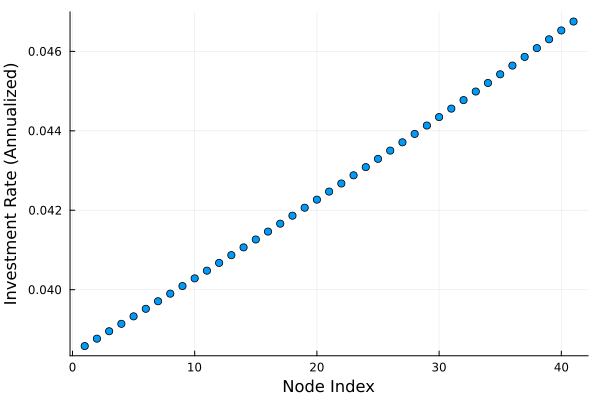

In [12]:
let

    # initialize -
    lattice = interest_rate_tree_4_week;
    all_possible_interest_rates = Array{Float64}(undef, length(lattice.data));
    for (i,data) ∈ lattice.data
        all_possible_interest_rates[i+1] = data.quantity;
    end
    all_possible_interest_rates |> sort!;

    plot(
        future_interest_rates_array_4_week,
        seriestype = :scatter,
        xlabel = "Node Index",
        ylabel = "Investment Rate (Annualized)",
        legend = false,
    )

end

In [13]:
do_I_see_4_week_interest_rate_plot = true; # this is a flag to indicate that we have successfully plotted the 4-week interest rate lattice model

## Task 2: Lattice model for the investment rate of 52-week U.S. Treasury Bills
In this task, we will build a lattice model for the investment rate of 52-week U.S. Treasury Bills. The process is similar to Task 1, but we will use different parameters and a different initial interest rate.

In [ ]:
interest_rate_tree_52_week, parameters_52_week = let
    
    # initialize -
    μ₊ = 3.21; # up factor drift
    μₒ = 0.0; # neutral factor drift
    
    # compute the delta values for the interest rate tree -
    Δ = [
        exp(μ₊*Δt) , exp(μₒ*Δt), exp(-μ₊*Δt) # this is the amount by which the interest rate changes at each step (daily)
    ];
    r̄ = 0.0366; # initial interest rate (Issue date: 09/04/2025, Maturity: 10/03/2026, 52-week U.S. Treasury Bill)
    h = number_of_steps - 1; # number of time steps to project out

    # build an empty tree -
    interest_rate_tree = build(MyGeneralDiscreteRecombiningTreeModel, (
        n = n, h = h,
    )) |> tree -> populate!(tree, r̄, Δ);

    # let's package up the parameters for later use -
    parameters = (
        μ₊ = μ₊,
        μ₋ = -μ₊,
        μₒ = μₒ,
        Δ = Δ,
        r̄ = r̄,
    );

    interest_rate_tree, parameters # return
end;

Fill me in

In [16]:
future_interest_rates_array_52_week = let

    # initialize -
    lattice = interest_rate_tree_52_week;
    level_to_inspect = (number_of_steps - 1); # level to inspect in the lattice, this is the last level
    nodes_at_level = interest_rate_tree_52_week.levels[level_to_inspect];
    possible_interest_rates = Array{Float64}(undef, length(nodes_at_level));
    
    # let's fill the array with the interest rates at this level -
    for i ∈ eachindex(nodes_at_level)
        value = lattice.data[nodes_at_level[i]];
        possible_interest_rates[i] = value.quantity |> x-> round(x, digits=6); # extract the interest rate quantity from the node data
    end

    possible_interest_rates |> sort |> unique;
end

41-element Vector{Float64}:
 0.022358
 0.022916
 0.023488
 0.024074
 0.024674
 0.02529
 0.025921
 0.026568
 0.02723
 0.02791
 ⋮
 0.049194
 0.050421
 0.051679
 0.052968
 0.05429
 0.055644
 0.057032
 0.058455
 0.059914

Fill me in

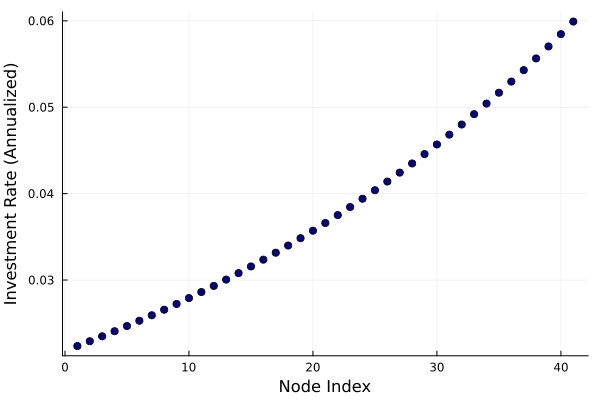

In [17]:
let

    plot(
        future_interest_rates_array_52_week,
        seriestype = :scatter,
        c = :navy,
        xlabel = "Node Index",
        ylabel = "Investment Rate (Annualized)",
        legend = false,
    )


end

## Task 3: Compute the Net Present Value of a U.S. Treasury Bill portfolio
Fill me in

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___